In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

#### Esercizi svolti da Stefano Polo

#### Matricola: 940175

#### Informazione sulla cartella contenente codici e risultati "Exercise 04.4"
La struttura della cartella è funzionale per una compilazione semplice del *notebook*. Infatti tutti i risultati delle simulazioni sono disposti nella cartella <span style="color:red"> Risultati </span> catalogati in base alla fase simulata (fase gassosa, liquida e solida). Di conseguenza al fine della compilazione del *notebook* non è necessario rieseguire le simulazioni. Nella cartella <span style="color:red">Codici</span> sono catalogati tutti i codici C++ delle simulazioni di ciascuna fase. La compilazione e l'esecuzione di quest'ultimi prevede l'automatica sovrascrittura dei file contenenti i risultati su quelli vecchi contenuti nella cartella <span style="color:red"> Risultati</span> (dunque un'esecuzione dei codici non richiede che i nuovi risultati vengano copiati a mano in <span style="color:red"> Risultati</span>). Per compilare e eseguire i codici è consigliabile eseguire il comando da terminale <span style="color:green">make esegui</span> (poiché automaticamente vengono eliminati i vecchi risultati con lo script "clean.sh"; operazione necessaria dal momento che la scrittura su file delle simulazioni sfrutta la modalità "ios::app"). 
Se invece si volesse compilare e eseguire tutte e tre le simulazioni (relative a fase solida, liquida e gassosa) è disponibile nella cartella <span style="color:red">Codici</span> uno "script.sh" che esegue tutto in automatico

# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 4</span>

Presento i risultati solo dell'esercizio <span style="color:red">"Exercise 04.4"</span> dal momento che in quelli precedenti era richiesto di migliorare il codice di dinamica molecolare in modo che fosse in grado di calcolare valori medi di determinate grandezze con i corrispondenti errori mediante il metodo del *data blocking* e che disponesse di un metodo per equilibrare il sistema prima dell'inizio della simulazione 

### Exercise 04.4

#### Informazioni sulla simulazione
Il codice di dinamica molecolare implementato utilizza l'algoritmo di Verlet per l'integrazione delle equazioni del moto di ciascuna particella . Il Verlet sfrutta posizione precedente e attuale di una particella per calcolarne la successiva; esso necessita di una configurazione di input da cui partire (in queste simulazioni la disposizione iniziale delle particelle sarà un reticolo fcc) ed è invariante per inversione temporale; tale invarianza gli garantisce la conservazione dell'energia totale del sistema (anche per tempi lunghi). Di conseguenza questo algoritmo è utile per simulare un insieme microcanonico (NVE). 

Il passo dell'algoritmo in queste simulazioni è fissato a $\tau^\star = 0.0005$.
Il codice che ho utilizzato opera in unità di misura di Lennard-Jones (unità di lunghezza $\sigma$; unità di energia $\epsilon$; unità di massa $m$). In questo modo è possibile con una sola simulazione eseguirne infinite grazie alla legge degli stati corrispondenti. 

In questo esercizio eseguo simulazioni di dinamica molecolare attraverso il modello di Lennard-Jones di Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) e Krypton ($\sigma = 0.364$ nm, $\epsilon/k_B = 164$ K, $m=83.798$ amu) nelle seguenti condizioni (si indica con un $\star$ ad apice le grandezze in unità ridotte):
1. fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c^\star = 2.2$)
2. fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c^\star = 2.5$)
3. fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c^\star = 5.0$)

Il sistema simulato si compone di una box cubica con condizioni periodiche al contorno contenente $n = 108$ particelle. 

Nelle simulazioni non sono state adottate le correzioni di coda per l'energia potenziale e il viriale (tuttavia nel codice è possibile scommentarle se lo si desidera)

#### Fase di equilibrazione
Lo scopo di ciascuna simulazione consiste nell'effettuare misure di temperatura $T$, energia cinetica $E_{kin}$, energia potenziale $E_{pot}$, energia totale $E_{tot}$ e pressione $P$ sul sistema all'equilibrio termico.

Dal momento che il sistema inizialmente non è all'equilibrio (posizioni iniziali di input di un fcc con velocità distribuite uniformemente), l'energia cinetica delle particelle evolve e, di conseguenza, la temperatura varia fino al raggiungimento dell'equilibrio. Dunque, se si vuole simulare il sistema alla temperatura  $T^\star$ richiesta, è necessaria una fase di equilibrazione. 

Il codice che ho implementato disponde di due metodi di equilibrazione (le temperature indicate sono tutte in unità ridotte):

- Riscalamento delle velocità (nel codice è la funzione <span style="color:green">Restart()</span>): il sistema viene fatto evolvere con il Verlet per un certo numero di passi. Ogni decina di passi vegono calcolate le velocità, da cui si ricava l'energia cinetica del sistema e di conseguenza la temperatura a cui si trova il sistema $T = \frac{2}{3} \frac{<\vec{v}^2>}{n}$, in cui $<\vec{v}^2>$ è la velocità quadratica media del sistema. La temperatura da raggiungere,$T^{\text{target}}$, viene utilizzata per riscalare le velocità del sistema: $\vec{v_i^{riscalata}}= \vec{v_i} \sqrt{3 \frac{T^{\text{target}}}{T}}$. Dato che è stata modificata la velocità è necessario ricalcolare la posizione di ogni particella $\vec{r_i}(t)= \vec{r_i}(t+dt) - 2dt\vec{v_i}$ come se essa si fosse mosse con velocità $\vec{v_i^{riscalata}}$ e non $\vec{v_i}$. Con questa posizione i calcola $ \vec{r}(t+dt) $ tramite l'algoritmo di Verlet.


- Equilibrazione spontanea (nel codice è la funzione <span style="color:green">Termalizzazione()</span>): la temperatura iniziale del sistema viene fissata a una precisa $T^{\text{start}}$ (scelta ad hoc per raggiungere la temperatura target $T^{\text{target}}$ alla quale si vuole simulare il sistema) e viene fatto evolvere finché non raggiunge come temperatura di equilibrio la $T^{\text{target}}$. La verifica di $T^{\text{target}}$ come temperatura di equilibrio viene viene fatta osservando il grafico delle temperature istantanee della simulazione. Se la temperatura istantanea oscilla attorno a $T^{\text{target}}$ allora l'equilibrio è stato raggiunto alla temperatura desiderata e si può procedere con la simulazione.

Sebbene il primo metodo risulti più "elegante", nelle simulazioni ho adottato il secondo in quanto mi ha permesso di raggiungere una temperatura di equilibrio più vicina alla $T^\star$ richiesta dall'esercizio. Mostro nella tabella sottostante la fase di equilibrazione di ciascuna fase del sistema. Si può osservare bene come per solido e liquido si abbia raggiunto l'equilibrio alla temperatura target. Tuttavia il gas risulta più difficile da termalizzare (è poco denso come sistema), nonostante gli siano stati lasciati più step per equilibrare (con il primo metodo non si riusciva ad equilibrarlo in modo ottimale). Queste sono le temperature iniziali dalle quali sono partite le simulazioni con la seconda tecnica di equilibrazione con i relativi step di equilibrazione:
- Solido: $T^{\text{start}} = 1.542$, numero di step = $4\times10^3$
- Liquido: $T^{\text{start}} = 1.98$, numero di step = $4\times10^3$
- Gas: $T^{\text{start}} = 0.96$, numero di step = $3\times10^4$

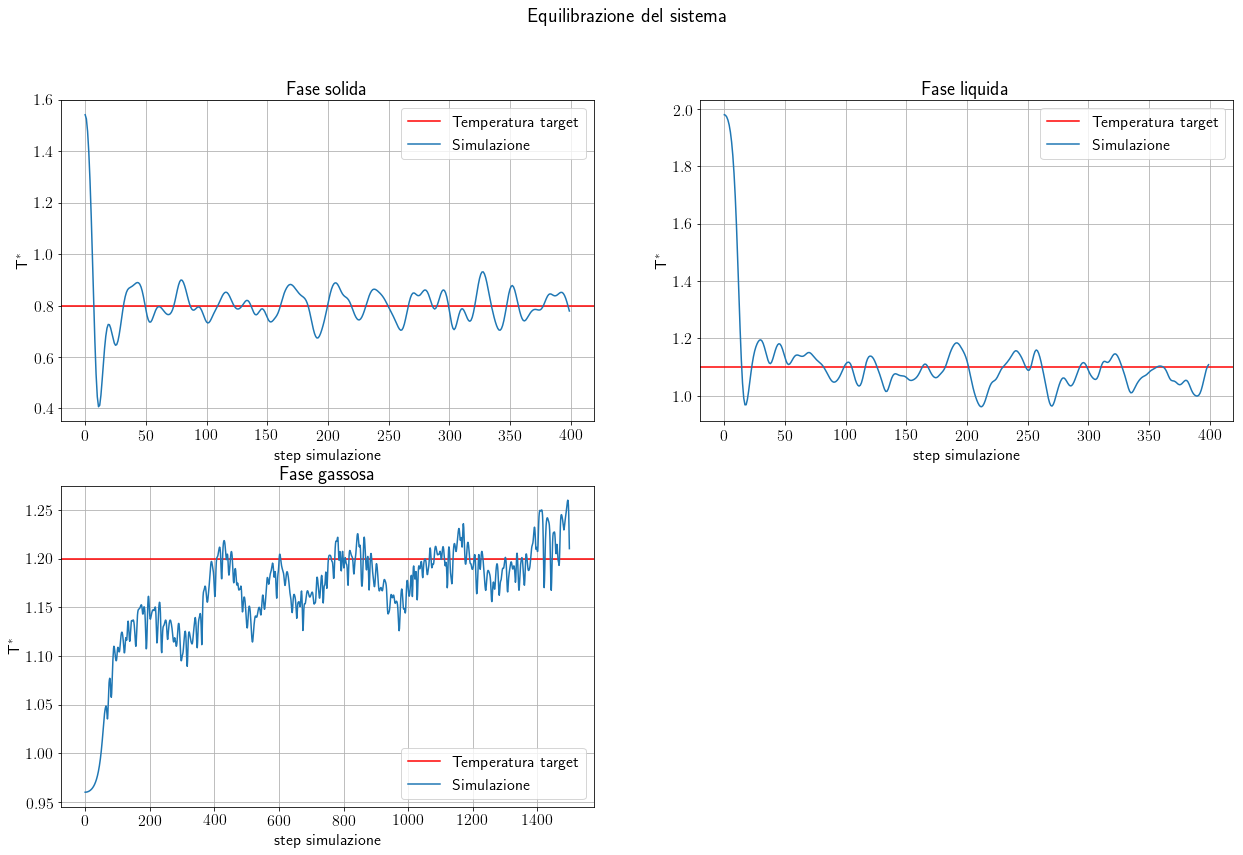

In [12]:
plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(21,13))
plt.suptitle('Equilibrazione del sistema',fontsize=20)

plt.subplot(2,2,1)
T = np.loadtxt('Risultati/Solid/output_restart.dat', usecols=(0), delimiter=' ', unpack='true')
plt.axhline(y=0.8,linestyle='-',color = 'red',label = 'Temperatura target')
plt.plot(T,label = 'Simulazione')
plt.title("Fase solida")
plt.ylabel(r'T$^*$')
plt.xlabel(r'step simulazione')
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
T = np.loadtxt('Risultati/Liquid/output_restart.dat', usecols=(0), delimiter=' ', unpack='true')
plt.axhline(y=1.1,linestyle='-',color = 'red',label = 'Temperatura target')
plt.plot(T,label = 'Simulazione')
plt.title("Fase liquida")
plt.ylabel(r'T$^*$')
plt.xlabel(r'step simulazione')
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
T = np.loadtxt('Risultati/Gas/output_restart.dat', usecols=(0), delimiter=' ', unpack='true')
plt.axhline(y=1.2,linestyle='-',color = 'red',label = 'Temperatura target')
plt.plot(T,label = 'Simulazione')
plt.ylabel(r'T$^*$')
plt.xlabel(r'step simulazione')
plt.title("Fase gassosa")
plt.legend()
plt.grid(True)
plt.show()

Terminata la fase di equilibrazione del sistema, la simulazione procede per un numero di blocchi $N_{block} = 100$ ciascuno composto da $10^3$ passi dell'algoritmo di Verlet. Dal momento che il Verlet fa evolvere dolcemente il sistema, ogni $10$ passi vengono calcolati i valori istantanei di temperatura, energia cinetica, energia potenziale, energia totale e pressione.
Infine questi valor istantanei delle grandezze di interesse vengono utilizzati per effettuare il *data blocking* con $100$ blocchi. Di seguito sono riportati i risultati (in unità SI) sia per l'argon sia per il krypton. Le grandezze hanno il medesimo andamento funzionale ma riscalamenti diversi delle stesse grandezze adimensionate (questo grazie alla legge degli stati corrispondenti)

#### Fase solida:
* la temperatura converge entro l'errore a $T =96.1\, \text{K}$  per l'argon e  $T =131.3\, \text{K}$ per il krypton (temperature richieste dall'esercizio: $96\, \text{K}$ per argon e $131\, \text{K}$ per krypton).
* L'energia potenziale è di un ordine di grandezza maggiore di quella cinetica, segno del fatto che il sistema è solido.
* Dopo una prima fase di stabilizzazione, l'energia totale è conservata.
* La pressione è molto maggiore di quella atmosferica come atteso perchè si formi un solido di gas nobile. 

#### Fase liquida:
* la temperatura inizialmente varia, converge entro l'errore a $T =132\, \text{K}$ per l'argon e  $T=180\, \text{K}$ per il krypton (temperature richieste dall'esercizio: $132\, \text{K}$ per argon e $180.4$ K per krypton).
* L'energia potenziale è dello stesso di grandezza maggiore di quella cinetica, segno del fatto che il sistema è liquido
* L'energia totale invece è ben conservata dal sistema come è auspicabile per una simulazione dell'inisieme microcanonico.
* La pressione è molto maggiore di quella atmosferica come atteso perchè si formi un liquido di gas nobile. 

#### Fase gassosa:
* la temperatura continua a variare fino a raggiungere un il sistema raggiunge stabilmente $T =145\, \text{K}$ per l'argon e  $T =198\, \text{K}$ per il krypton (temperature richieste dall'esercizio: $144\, \text{K}$ per argon e $196.8\, \text{K}$ per krypton). Il valore ottenuto si discosta da quello richiesto a causa della difficoltà nell'equilibrare il sistema in fase gassosa
* L'energia potenziale è di un ordine di grandezza minore di quella cinetica, segno del fatto che il sistema è gassoso
* L'energia totale è conservata entro l'errore, come richiesto per una simulazione affidabile.
* La pressione pur rimanendo maggiore di quella atmosferica risulta nettamente minore rispetto a quella del solido e del liquido.

## Argon

Nella cella sottostante vengono inizializzate le unità di Lennard-Jones per l'Argon 

In [13]:
Kb = 1.38E-23  #costante di boltzmann
sigma = 0.34*(10**(-9))   #unità di lunghezza in metri
e_Kb = 120.   #e/Kb     per la temperatura in kelvin
e = (e_Kb*Kb)   #energia in J
e_eV = e/(1.6*10**(-19))   #energia  in eV
p = e/(sigma**3)     #pressione in Pa 
p_atm = p/101325.  #pressione in atmosfere
m_au = 39.948
m = m_au*1.66054e-27   #Kg
t = sigma*np.sqrt(m/e)

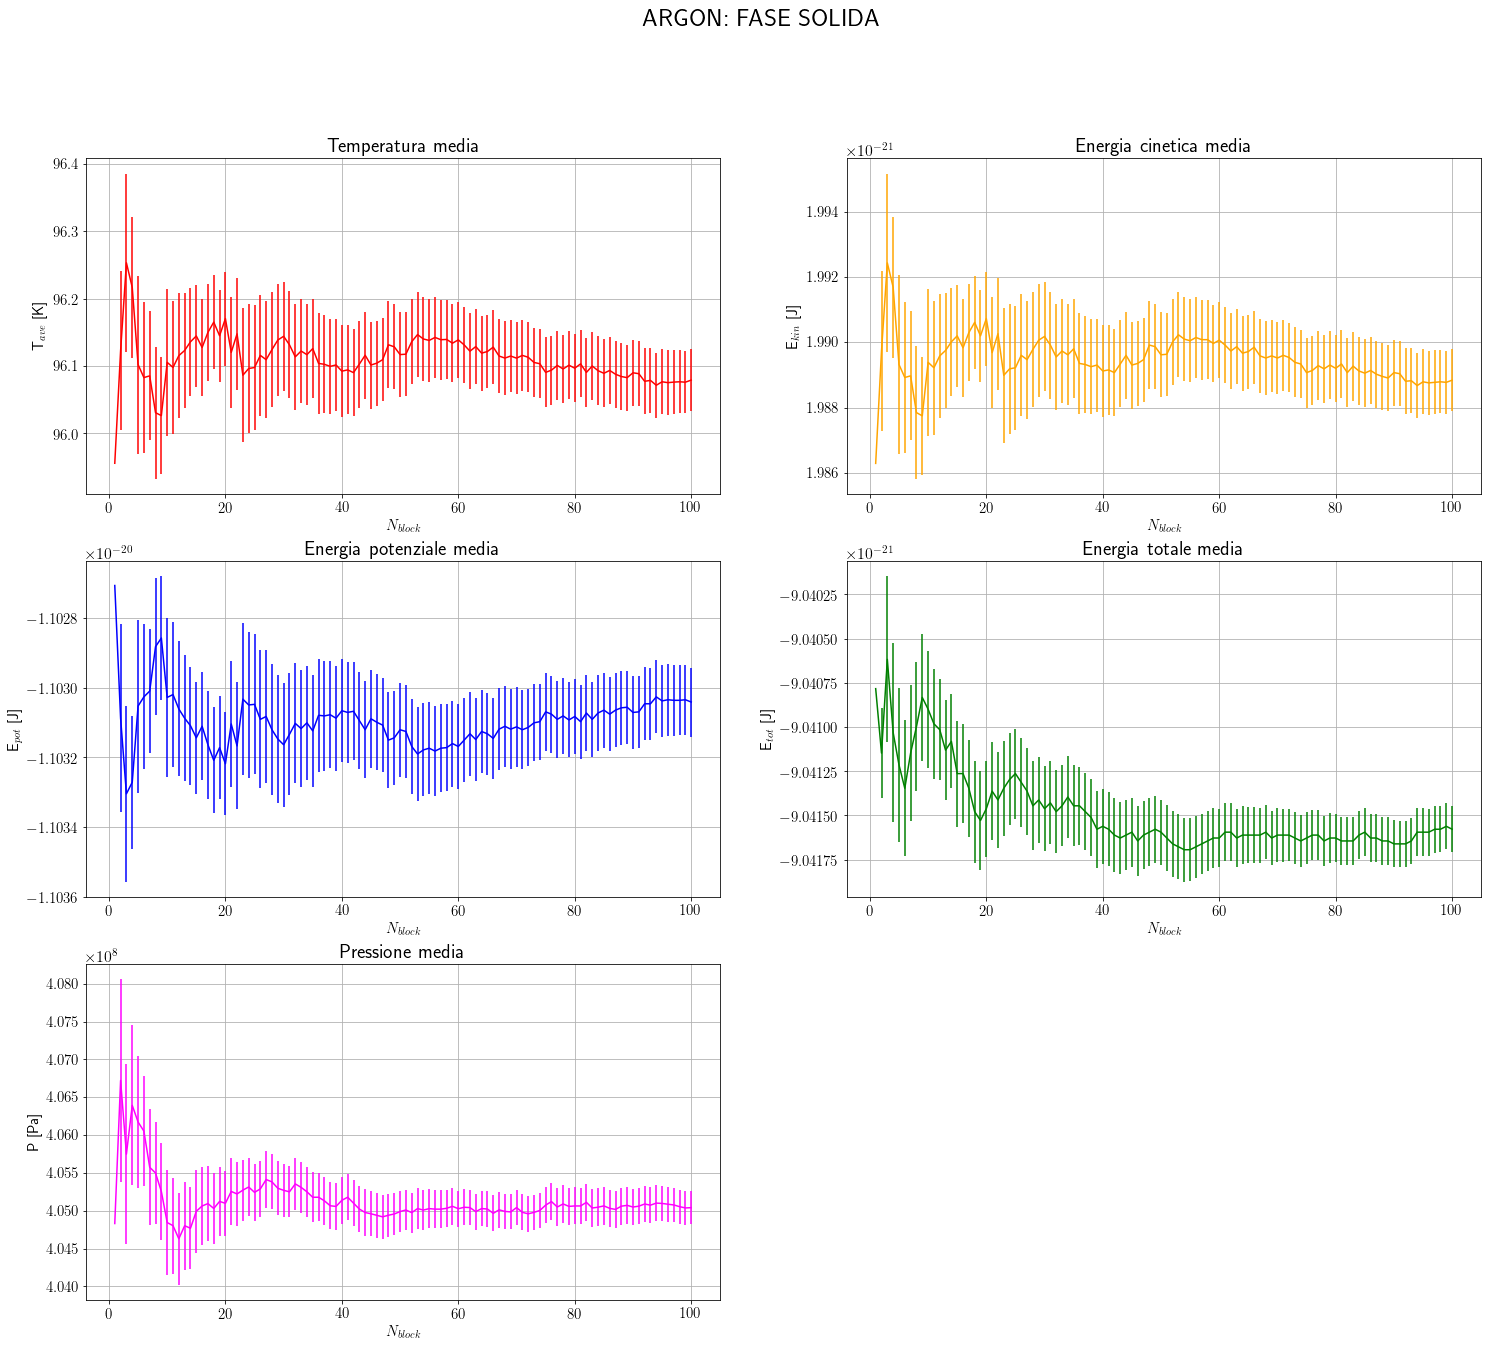

In [14]:
plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,21))
plt.suptitle('ARGON: FASE SOLIDA',fontsize=25)

plt.subplot(3,2,1)
N, r, error = np.loadtxt('Risultati/Solid/ave_temp.out', usecols=(0,1,2), unpack='true')
plt.title("Temperatura media",fontsize=20)
plt.errorbar(N,r*e_Kb,yerr=error*e_Kb,color='red')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$N_{block}$', fontsize=15)
plt.ylabel('T$_{ave}$ [K]', fontsize = 15)
plt.grid(True)

plt.subplot(3,2,2)

N, r, error = np.loadtxt('Risultati/Solid/ave_ekin.out', usecols=(0,1,2), unpack='true')
plt.title("Energia cinetica media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='orange')
plt.xlabel(r'$N_{block}$', fontsize=15)
plt.ylabel('E$_{kin}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,3)
N, r, error = np.loadtxt('Risultati/Solid/ave_epot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia potenziale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='blue')
plt.xlabel(r'$N_{block}$', fontsize=15)
plt.ylabel('E$_{pot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,4)
N, r, error = np.loadtxt('Risultati/Solid/ave_etot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia totale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color ='green')
plt.xlabel(r'$N_{block}$', fontsize=15)
plt.ylabel('E$_{tot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,5)

N, r, error = np.loadtxt('Risultati/Solid/ave_pres.out', usecols=(0,1,2), unpack='true')
plt.title("Pressione media",fontsize=20)
plt.errorbar(N,r*p,yerr=error*p, color='magenta')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('P [Pa]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.show()

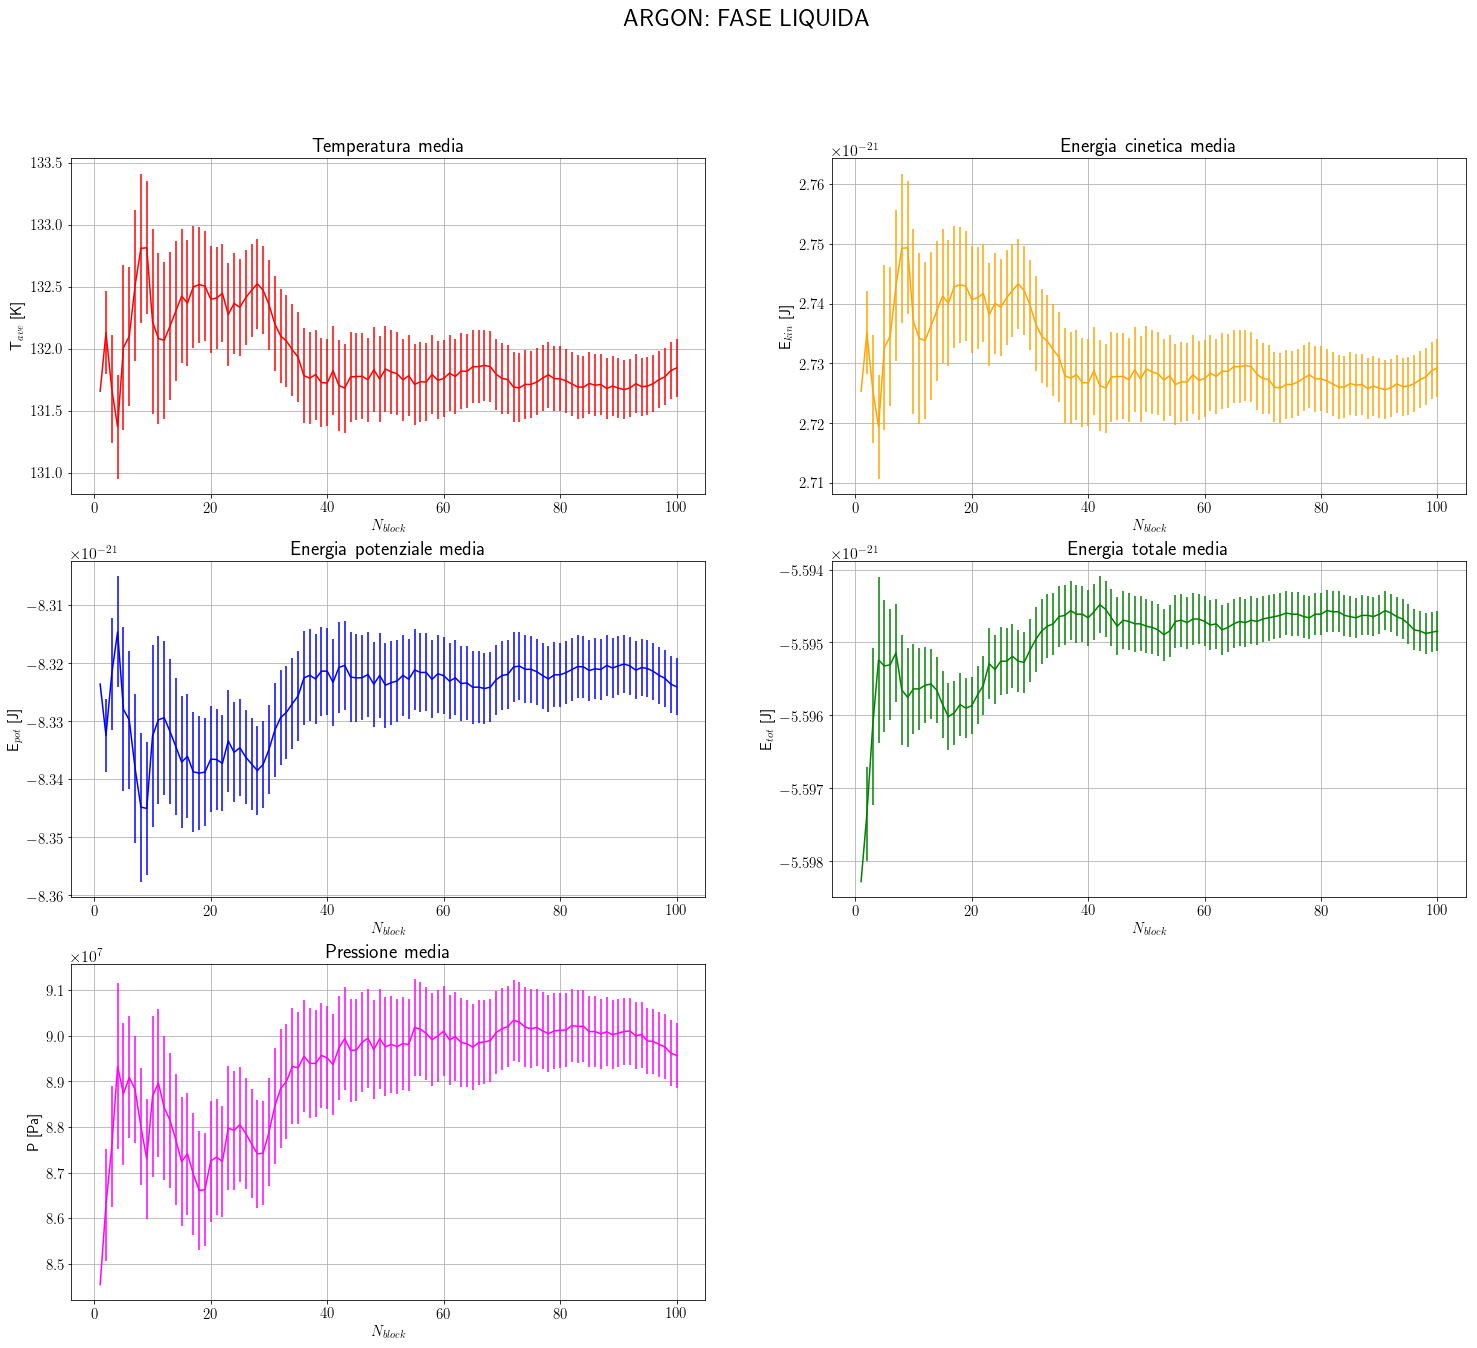

In [15]:
plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,21))
plt.suptitle('ARGON: FASE LIQUIDA',fontsize=25)

plt.subplot(3,2,1)
N, r, error = np.loadtxt('Risultati/Liquid/ave_temp.out', usecols=(0,1,2), unpack='true')
plt.title("Temperatura media",fontsize=20)
plt.errorbar(N,r*e_Kb,yerr=error*e_Kb,color='red')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$N_{block}$', fontsize=15)
plt.ylabel(r'T$_{ave}$ [K]', fontsize = 15)
plt.grid(True)

plt.subplot(3,2,2)

N, r, error = np.loadtxt('Risultati/Liquid/ave_ekin.out', usecols=(0,1,2), unpack='true')
plt.title("Energia cinetica media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='orange')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{kin}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,3)
N, r, error = np.loadtxt('Risultati/Liquid/ave_epot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia potenziale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='blue')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{pot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,4)
N, r, error = np.loadtxt('Risultati/Liquid/ave_etot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia totale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color ='green')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{tot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,5)

N, r, error = np.loadtxt('Risultati/Liquid/ave_pres.out', usecols=(0,1,2),  unpack='true')
plt.title("Pressione media",fontsize=20)
plt.errorbar(N,r*p,yerr=error*p, color='magenta')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('P [Pa]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)



plt.show()

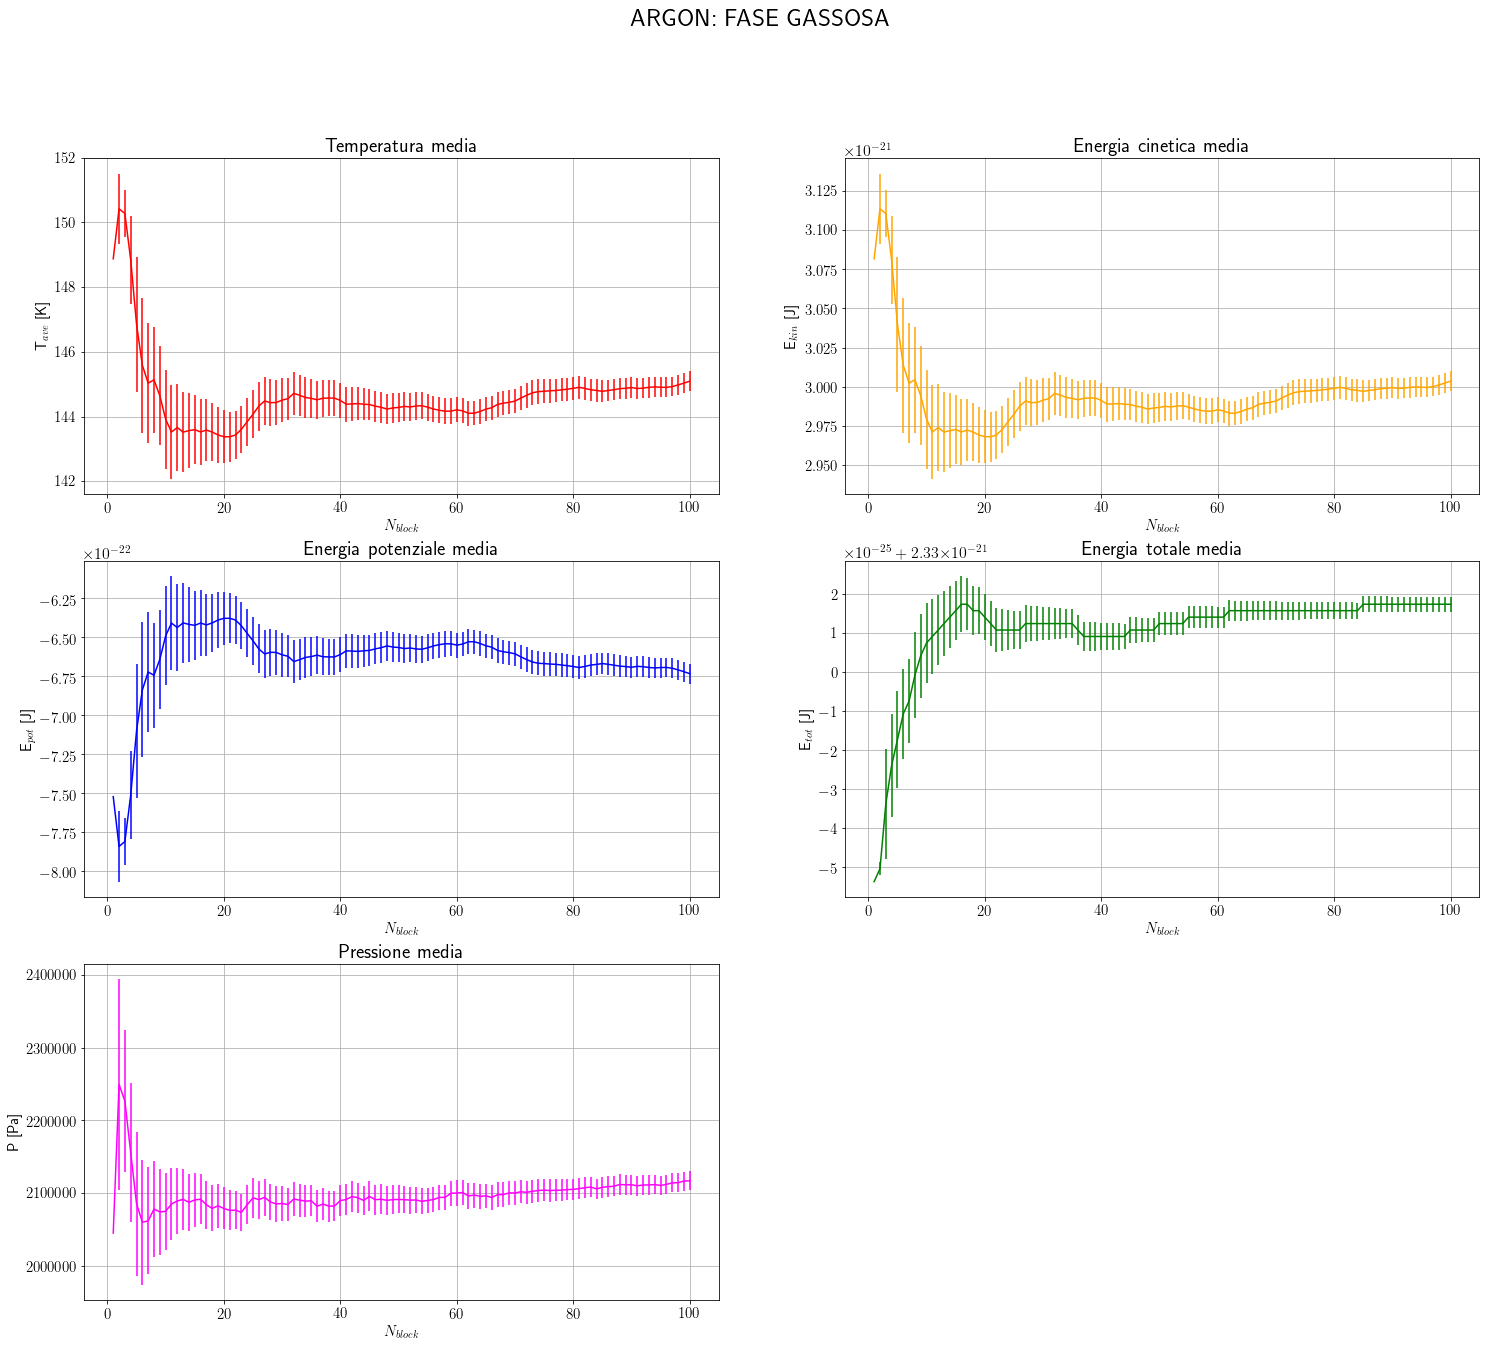

In [16]:
plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,21))
plt.suptitle('ARGON: FASE GASSOSA',fontsize=25)

plt.subplot(3,2,1)
N, r, error = np.loadtxt('Risultati/Gas/ave_temp.out', usecols=(0,1,2), unpack='true')
plt.title("Temperatura media",fontsize=20)
plt.errorbar(N,r*e_Kb,yerr=error*e_Kb,color='red')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('T$_{ave}$ [K]', fontsize = 15)
plt.grid(True)
plt.subplot(3,2,2)

N, r, error = np.loadtxt('Risultati/Gas/ave_ekin.out', usecols=(0,1,2), unpack='true')
plt.title("Energia cinetica media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='orange')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{kin}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,3)
N, r, error = np.loadtxt('Risultati/Gas/ave_epot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia potenziale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='blue')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{pot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,4)
N, r, error = np.loadtxt('Risultati/Gas/ave_etot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia totale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color ='green')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{tot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,5)

N, r, error = np.loadtxt('Risultati/Gas/ave_pres.out', usecols=(0,1,2), unpack='true')
plt.title("Pressione media",fontsize=20)
plt.errorbar(N,r*p,yerr=error*p, color='magenta')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('P [Pa]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)


plt.show()

## Krypton

Nella cella sottostante vengono inizializzate le unità di Lennard-Jones per il Krypton

In [17]:
Kb = 1.38E-23   #costante di boltzmann
sigma = 0.364*(10**(-9))   # per lunghezza in metri
e_Kb = 164.   #e/Kb     for temperatura in K
e = (e_Kb*Kb)   #energia in J
e_eV = e/(1.6*10**(-19))   #energia in eV
p = e/(sigma**3)     #pressione in Pa 
p_atm = p/101325.   #pressione in atmosfere
m_au = 83.798
m = m_au*1.66054e-27   #Kg
t = sigma*np.sqrt(m/e)

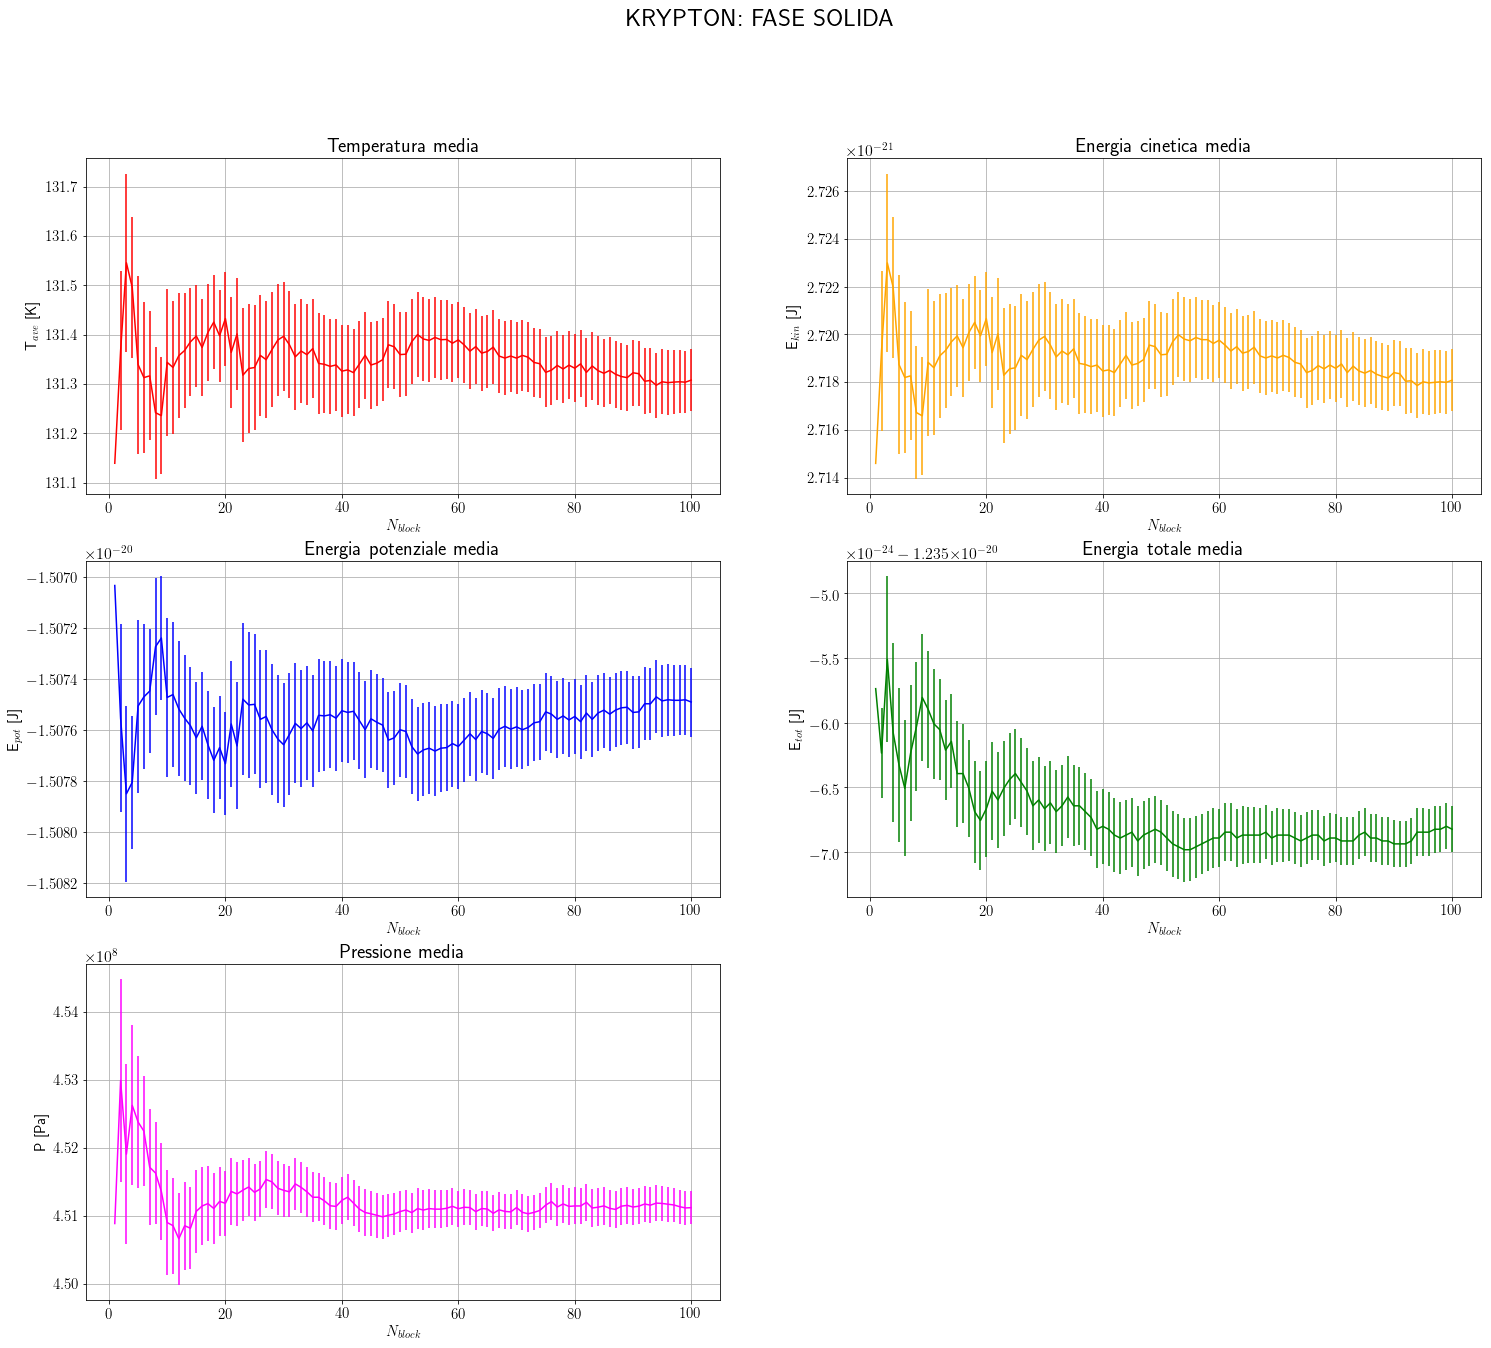

In [18]:
plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,21))
plt.suptitle('KRYPTON: FASE SOLIDA',fontsize=25)

plt.subplot(3,2,1)
N, r, error = np.loadtxt('Risultati/Solid/ave_temp.out', usecols=(0,1,2), unpack='true')
plt.title("Temperatura media",fontsize=20)
plt.errorbar(N,r*e_Kb,yerr=error*e_Kb,color='red')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$N_{block}$', fontsize=15)
plt.ylabel('T$_{ave}$ [K]', fontsize = 15)
plt.grid(True)

plt.subplot(3,2,2)

N, r, error = np.loadtxt('Risultati/Solid/ave_ekin.out', usecols=(0,1,2), unpack='true')
plt.title("Energia cinetica media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='orange')
plt.xlabel(r'$N_{block}$', fontsize=15)
plt.ylabel('E$_{kin}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,3)
N, r, error = np.loadtxt('Risultati/Solid/ave_epot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia potenziale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='blue')
plt.xlabel(r'$N_{block}$', fontsize=15)
plt.ylabel('E$_{pot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,4)
N, r, error = np.loadtxt('Risultati/Solid/ave_etot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia totale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color ='green')
plt.xlabel(r'$N_{block}$', fontsize=15)
plt.ylabel('E$_{tot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,5)

N, r, error = np.loadtxt('Risultati/Solid/ave_pres.out', usecols=(0,1,2), unpack='true')
plt.title("Pressione media",fontsize=20)
plt.errorbar(N,r*p,yerr=error*p, color='magenta')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('P [Pa]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.show()

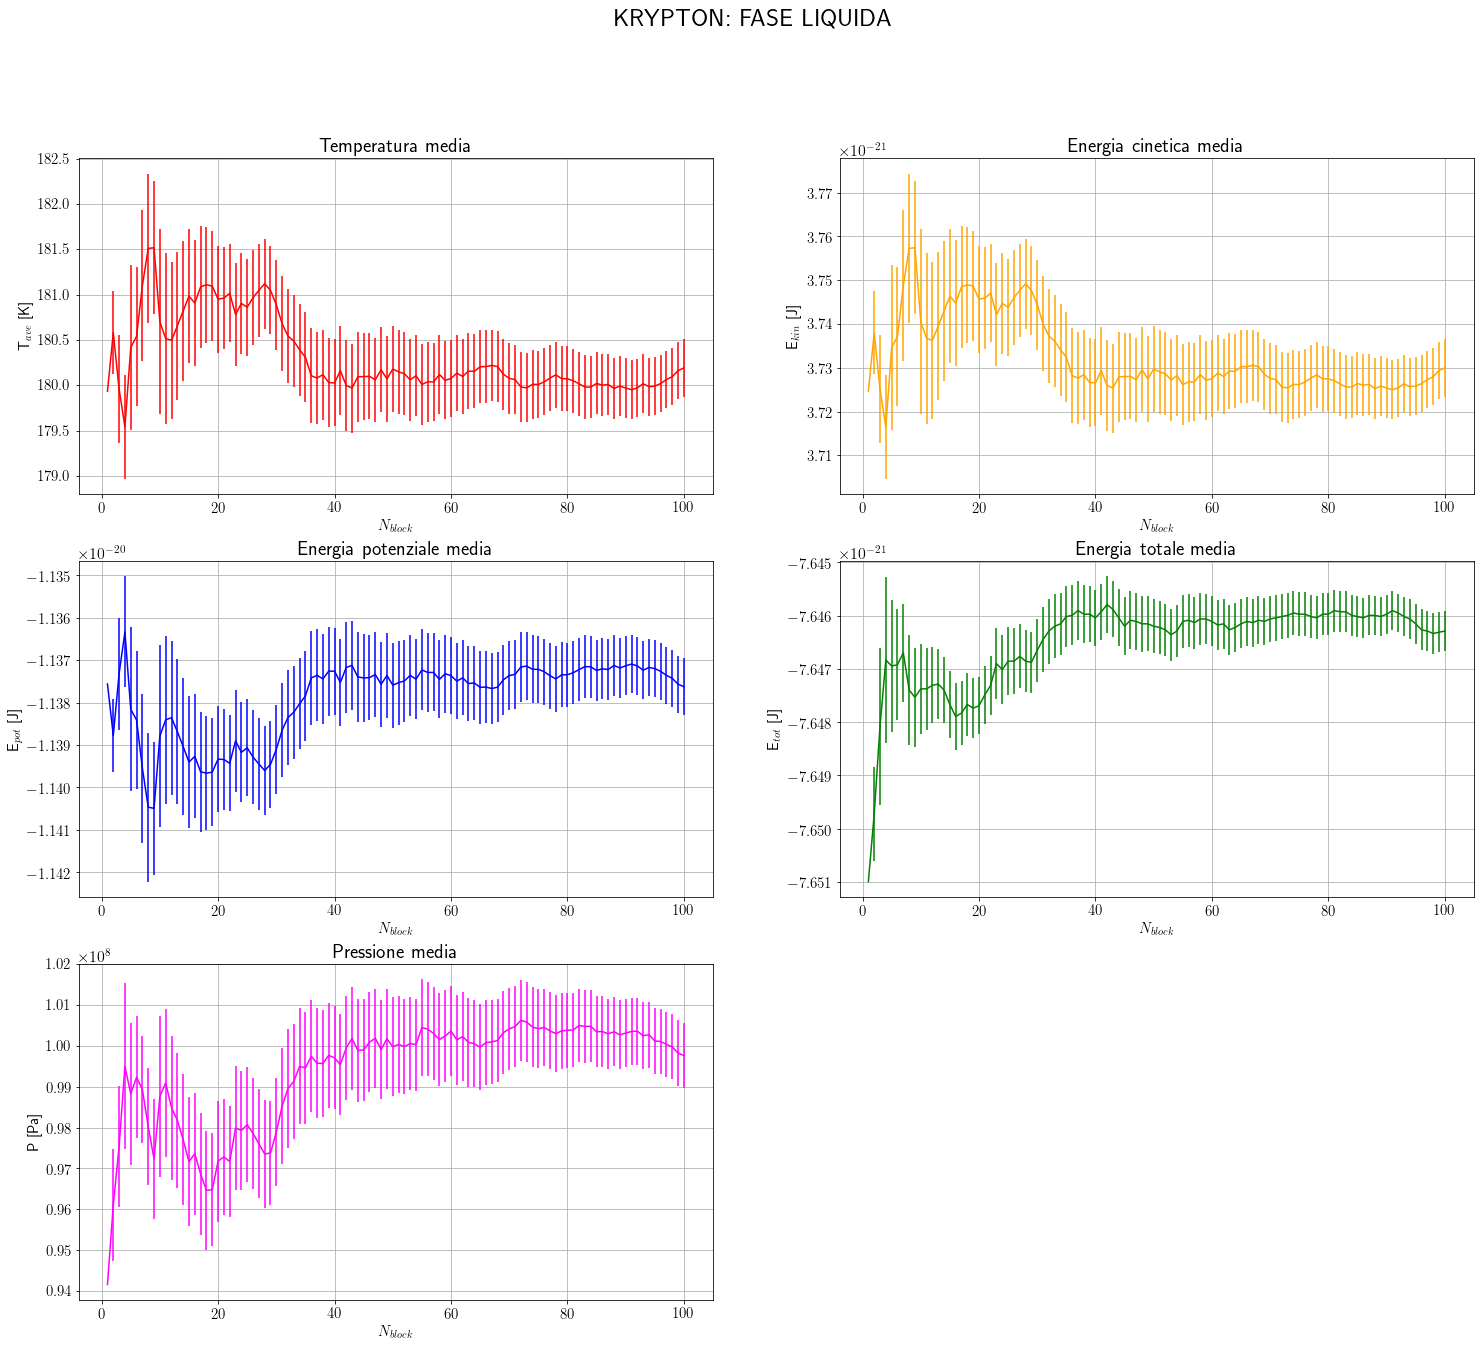

In [19]:
plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,21))
plt.suptitle('KRYPTON: FASE LIQUIDA',fontsize=25)

plt.subplot(3,2,1)
N, r, error = np.loadtxt('Risultati/Liquid/ave_temp.out', usecols=(0,1,2), unpack='true')
plt.title("Temperatura media",fontsize=20)
plt.errorbar(N,r*e_Kb,yerr=error*e_Kb,color='red')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$N_{block}$', fontsize=15)
plt.ylabel(r'T$_{ave}$ [K]', fontsize = 15)
plt.grid(True)

plt.subplot(3,2,2)

N, r, error = np.loadtxt('Risultati/Liquid/ave_ekin.out', usecols=(0,1,2), unpack='true')
plt.title("Energia cinetica media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='orange')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{kin}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,3)
N, r, error = np.loadtxt('Risultati/Liquid/ave_epot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia potenziale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='blue')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{pot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,4)
N, r, error = np.loadtxt('Risultati/Liquid/ave_etot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia totale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color ='green')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{tot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,5)

N, r, error = np.loadtxt('Risultati/Liquid/ave_pres.out', usecols=(0,1,2),  unpack='true')
plt.title("Pressione media",fontsize=20)
plt.errorbar(N,r*p,yerr=error*p, color='magenta')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('P [Pa]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)



plt.show()

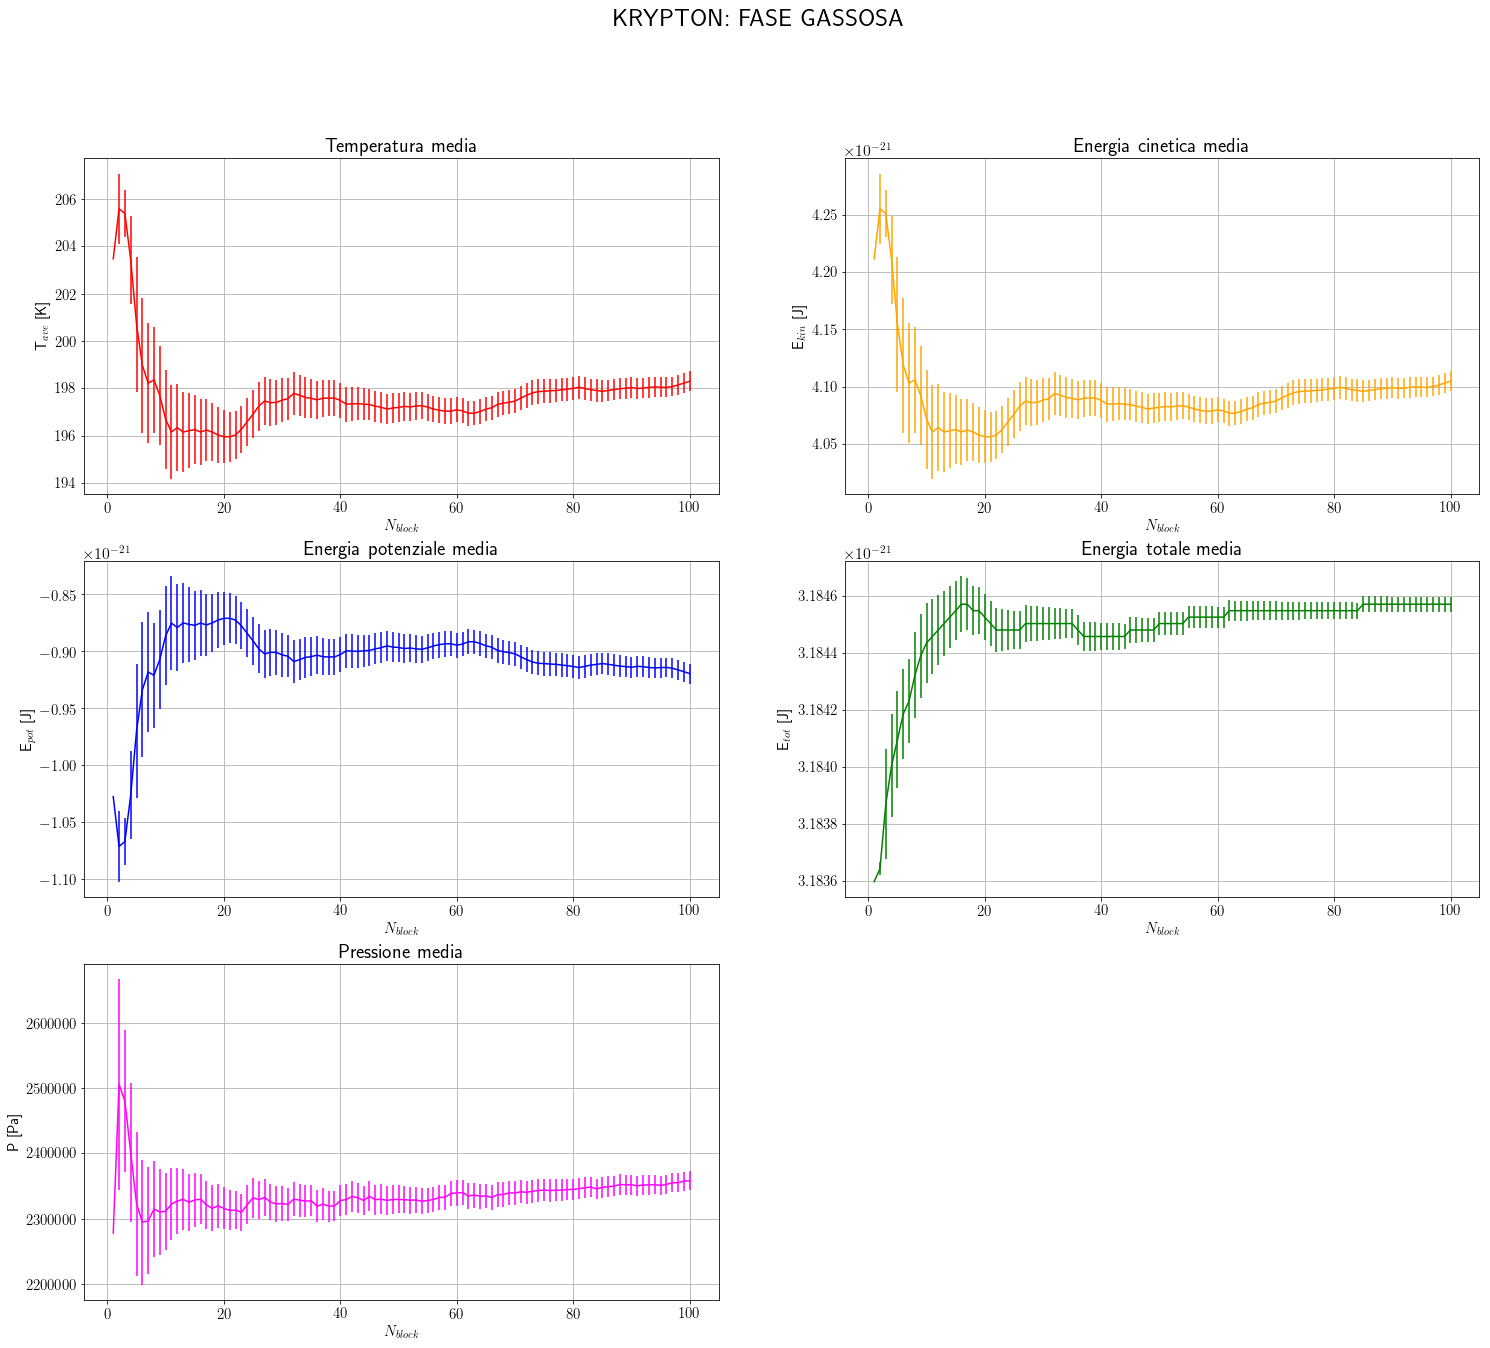

In [20]:
plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,21))
plt.suptitle('KRYPTON: FASE GASSOSA',fontsize=25)

plt.subplot(3,2,1)
N, r, error = np.loadtxt('Risultati/Gas/ave_temp.out', usecols=(0,1,2), unpack='true')
plt.title("Temperatura media",fontsize=20)
plt.errorbar(N,r*e_Kb,yerr=error*e_Kb,color='red')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('T$_{ave}$ [K]', fontsize = 15)
plt.grid(True)

plt.subplot(3,2,2)

N, r, error = np.loadtxt('Risultati/Gas/ave_ekin.out', usecols=(0,1,2), unpack='true')
plt.title("Energia cinetica media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='orange')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{kin}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,3)
N, r, error = np.loadtxt('Risultati/Gas/ave_epot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia potenziale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color='blue')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{pot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,4)
N, r, error = np.loadtxt('Risultati/Gas/ave_etot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia totale media",fontsize=20)
plt.errorbar(N,r*e,yerr=error*e,color ='green')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('E$_{tot}$ [J]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.subplot(3,2,5)

N, r, error = np.loadtxt('Risultati/Gas/ave_pres.out', usecols=(0,1,2), unpack='true')
plt.title("Pressione media",fontsize=20)
plt.errorbar(N,r*p,yerr=error*p, color='magenta')
plt.xlabel('$N_{block}$', fontsize=15)
plt.ylabel('P [Pa]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)


plt.show()